# Transformers for Market Movement Prediction

# Setup

In [1]:
!pip install quandl

In [2]:
# Import the quandl python package.
import quandl

# Package for scientific computing.
import numpy as np 

# Package for tabular data manipulation and analysis.
import pandas as pd

# Package for machine learning.
import tensorflow as tf
from tensorflow import keras

# Package for manipulating dates and times.
from datetime import datetime

# Plotting libraries.
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
%matplotlib inline

In [3]:
# Setting the API key for authentication.
quandl.ApiConfig.api_key = pass # Enter your API key as a string

# Data

For this project, we will use one of the most volatile assets in the digital assets market -- Bitcoin.

<img src="images/bitcoin.jpeg" alt="Bitcoin">

## Get the Data

In [4]:
# Set the interval for which you need the data.
t_start = '2016-01-01'
t_end = datetime.today().strftime('%Y-%m-%d')

# Get the required data through quandl API.
PriceData = quandl.get("BCHAIN/MKPRU", start_date=t_start, end_date=t_end)

PriceData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2008 entries, 2016-01-01 to 2021-06-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   2008 non-null   float64
dtypes: float64(1)
memory usage: 31.4 KB


In [5]:
PriceData.head()

,Value
Date,
2016-01-01,432.33
2016-01-02,433.94
2016-01-03,432.76
2016-01-04,433.00
2016-01-05,431.90


In [6]:
data = PriceData.copy()

data.rename(columns={"Value" : "price"}, inplace=True)

data.head()

,price
Date,
2016-01-01,432.33
2016-01-02,433.94
2016-01-03,432.76
2016-01-04,433.00
2016-01-05,431.90


## Process the Retrieved Data

In [7]:
# Returns (log scale).
data["log_return"] = np.log(data["price"] / data["price"].shift(1))
data.dropna(inplace=True)

data.head()

,price,log_return
Date,,
2016-01-02,433.94,0.003717
2016-01-03,432.76,-0.002723
2016-01-04,433.00,0.000554
2016-01-05,431.90,-0.002544
2016-01-06,432.43,0.001226


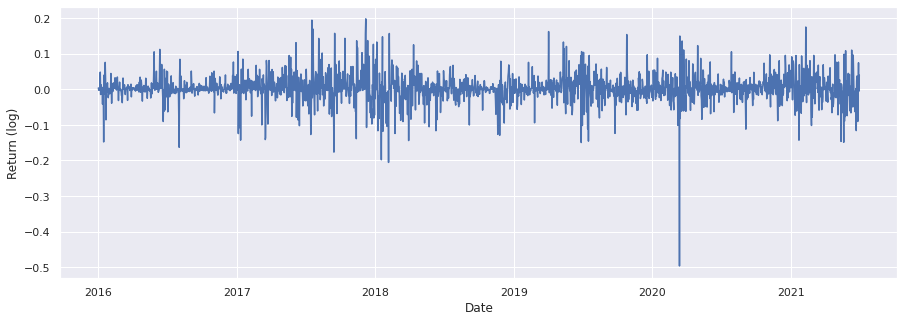

In [8]:
# Plot of returns over time (log scale).
plt.figure(figsize=(15, 5))
ax = sns.lineplot(data=data["log_return"], legend=False)
ax.set(xlabel='Date', ylabel='Return (log)')
plt.show()

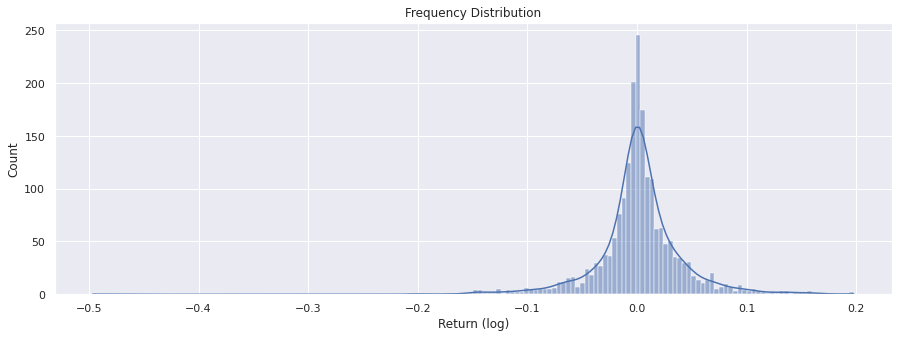

In [9]:
# Returns distribution (log scale)(not normalized).
plt.figure(figsize=(15, 5))
ax = sns.histplot(data=data['log_return'], kde=True)
ax.set(xlabel='Return (log)', ylabel='Count', title='Frequency Distribution')
plt.show()

In [10]:
# Preferred position.
# 1 -> long, 0 -> short
data["direction"] = np.where(data["log_return"] > 0, 1, 0)

data.head()

,price,log_return,direction
Date,,,
2016-01-02,433.94,0.003717,1
2016-01-03,432.76,-0.002723,0
2016-01-04,433.00,0.000554,1
2016-01-05,431.90,-0.002544,0
2016-01-06,432.43,0.001226,1


In [11]:
# Last 'lags' days returns (log scale).
lags = 7

cols = []  # List of feature names. 
for lag in range(lags, 0, -1): 
  col = f'log_return_lag_{lag}'
  data[col] = data['log_return'].shift(lag) 
  cols.append(col)

data.dropna(inplace=True)

data.head()

,price,log_return,direction,log_return_lag_7,log_return_lag_6,log_return_lag_5,log_return_lag_4,log_return_lag_3,log_return_lag_2,log_return_lag_1
Date,,,,,,,,,,
2016-01-09,452.64,0.012449,1,0.003717,-0.002723,0.000554,-0.002544,0.001226,0.048038,-0.014810
2016-01-10,446.24,-0.014240,0,-0.002723,0.000554,-0.002544,0.001226,0.048038,-0.014810,0.012449
2016-01-11,447.11,0.001948,1,0.000554,-0.002544,0.001226,0.048038,-0.014810,0.012449,-0.014240
2016-01-12,447.98,0.001944,1,-0.002544,0.001226,0.048038,-0.014810,0.012449,-0.014240,0.001948
2016-01-13,429.57,-0.041964,0,0.001226,0.048038,-0.014810,0.012449,-0.014240,0.001948,0.001944


## Split the Data

In [12]:
# Divide the data into training, validation and test datasets.
cutoff_train = '2021-01-01'
cutoff_val = '2021-04-01'

# Training data.
training_data = data[data.index < cutoff_train].copy()

# Validation data.
val_data = data[(data.index >= cutoff_train) & (data.index < cutoff_val)].copy()

# Test data.
test_data = data[data.index >= cutoff_val].copy()

In [13]:
training_data.tail(), val_data.tail(), test_data.tail()

(               price  log_return  ...  log_return_lag_2  log_return_lag_1
 Date                              ...                                    
 2020-12-27  26443.21    0.068456  ...          0.019680          0.040413
 2020-12-28  26246.58   -0.007464  ...          0.040413          0.068456
 2020-12-29  27036.69    0.029659  ...          0.068456         -0.007464
 2020-12-30  27376.37    0.012485  ...         -0.007464          0.029659
 2020-12-31  28856.59    0.052658  ...          0.029659          0.012485
 
 [5 rows x 10 columns],
                price  log_return  ...  log_return_lag_2  log_return_lag_1
 Date                              ...                                    
 2021-03-27  55074.47    0.068738  ...         -0.036817         -0.021022
 2021-03-28  55863.93    0.014233  ...         -0.021022          0.068738
 2021-03-29  55783.71   -0.001437  ...          0.068738          0.014233
 2021-03-30  57627.67    0.032521  ...          0.014233         -0.001437

# Model Architecture

## Custom Layers

In [14]:
class EncoderLayer(keras.layers.Layer):
  def __init__(self, num_heads, n_layers, n_neurons, rate=0.1, **kwargs):
    super(EncoderLayer, self).__init__(**kwargs)

    self.mha = keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=1)

    self.hidden = [keras.layers.Dense(n_neurons, 
                                      activation="elu",
                                      kernel_initializer="he_normal")
                  for _ in range(n_layers)]

    self.out = keras.layers.Dense(1)

    self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = keras.layers.Dropout(rate)
    self.dropout2 = keras.layers.Dropout(rate)

  def call(self, inputs, training):
    attn_output = self.mha(inputs, inputs)  
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(inputs + attn_output)

    Z = out1
    for layer in self.hidden: 
      Z = layer(Z)
    
    Z = self.dropout2(Z, training=training)

    ffn_output = self.out(Z)

    out2 = self.layernorm2(out1 + ffn_output)

    return out2

In [15]:
class Encoder(keras.layers.Layer):
  def __init__(self, n_enc_layers, n_heads, n_layers, n_neurons, maximum_position_encoding, rate=0.1, **kwargs):
    super(Encoder, self).__init__(**kwargs)

    self.pos_encoding = PositionEmbedding(maximum_position_encoding, 1)

    self.enc_layers = [EncoderLayer(n_heads, n_layers, n_neurons) for _ in range(n_enc_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

    self.pooling = tf.keras.layers.GlobalAveragePooling1D()

  def call(self, inputs, training):
    x = self.pos_encoding(inputs)

    x = self.dropout(x, training=training)

    for layer in self.enc_layers:
      x = layer(x, training)

    return self.pooling(x)

In [16]:
class PositionEmbedding(keras.layers.Layer):
    def __init__(self, maxlen, embed_dim):
        super(PositionEmbedding, self).__init__()
        self.layernorm = keras.layers.LayerNormalization()
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
        self.maxlen = maxlen

    def call(self, inputs):
        x = self.layernorm(inputs)

        positions = tf.range(start=0, limit=self.maxlen, delta=1)
        positions = self.pos_emb(positions)
        
        return x[:, np.newaxis] + positions

In [17]:
class FFN(keras.layers.Layer):
  def __init__(self, n_layers=4, n_neurons=20, **kwargs):
    super(FFN, self).__init__(**kwargs)

    self.hidden = [keras.layers.Dense(n_neurons, 
                                      activation="elu", 
                                      kernel_initializer="he_normal")
                  for _ in range(n_layers)]

    self.norm = [tf.keras.layers.LayerNormalization() for _ in range(n_layers)]

    self.out = keras.layers.Dense(1, activation="sigmoid")

  def call(self, inputs): 
    Z = inputs

    for hidden_layer, norm_layer in zip(self.hidden, self.norm): 
      Z = hidden_layer(Z)
      Z = norm_layer(Z)

    output = self.out(Z)

    return output

## Model

In [18]:
class CustomModel(keras.Model):
  def __init__(self,
               maximum_position_encoding,
               num_enc_layers = 1, num_heads = 2, n_layers = 1, n_neurons=64,
               n_layers_ffn = 4, n_neurons_ffn = 20,
               **kwargs):
    super(CustomModel, self).__init__(**kwargs) 
    
    self.transformer = Encoder(num_enc_layers, num_heads, n_layers, n_neurons, maximum_position_encoding)

    self.ffn = FFN(n_layers_ffn, n_neurons_ffn)

  def call(self, inputs, training): 
    Z = self.transformer(inputs)

    output = self.ffn(Z)
    
    return output

# Training

In [19]:
def set_seeds(seed=100): 
  np.random.seed(seed) 
  tf.random.set_seed(100)

# Set the random seed.
set_seeds()

In [20]:
# Instantiate a model.
model = CustomModel(lags)

In [21]:
# Learning rate as a function of epoch.
def sin_fn(epoch):
  if epoch > 100: return 0.001
  return tf.sin(epoch*0.1)*0.001 + 0.002

# Learning rate scheduler.
lr_scheduler = keras.callbacks.LearningRateScheduler(sin_fn)

In [22]:
# Optimizer.
optimizer = tf.keras.optimizers.Adam()

In [23]:
# Compile the model.
model.compile(optimizer, "binary_crossentropy", metrics=["accuracy"])

In [24]:
# Early-stopping callback.
early_stopping_cb = keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)

In [25]:
# Fit the model.
history = model.fit(training_data[cols], training_data["direction"], 
                    epochs=200, 
                    validation_data=(val_data[cols], val_data["direction"]), 
                    callbacks=[early_stopping_cb, lr_scheduler], 
                    shuffle=False, verbose=False)

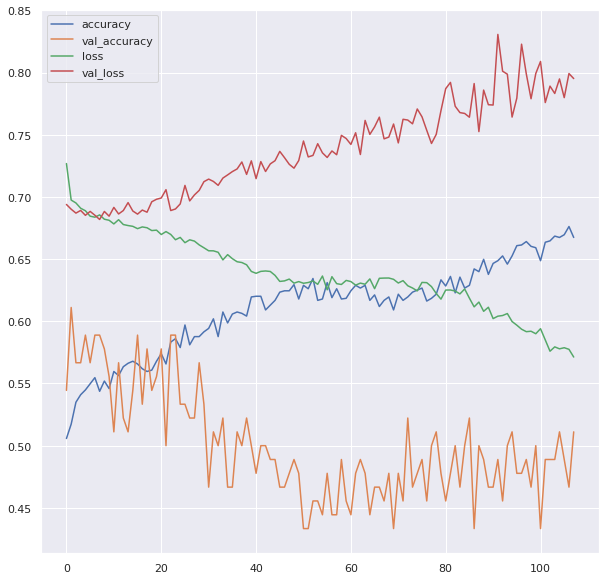

In [26]:
# Training characteristics.
res = pd.DataFrame(history.history)[["accuracy", "val_accuracy", "loss", "val_loss"]]

# Plot the training characteristics.
res.plot(figsize=(10, 10));

We can also perform hyperparameter tuning to find the best hyperparameters, but we will not do that due to the limited amount of computational resources.

# Evaluate

In [27]:
# Evaluate the model on test data.
model.evaluate(test_data[cols], test_data["direction"])

3/3 [==============================] - 0s 5ms/step - loss: 0.7037 - accuracy: 0.5275


[0.7037481069564819, 0.5274725556373596]

In [28]:
# Predicted preferred position.
# 1 -> long, -1 -> short.
test_data['prediction'] = np.where(model.predict(test_data[cols]) > 0.5, 1, -1)

In [29]:
# Strategy based returns (log scale).
test_data['strategy'] = test_data['prediction'] * test_data['log_return']

In [30]:
# Final returns based on the passive benchmark investment and strategy (regular scale).
returns = test_data[['log_return', 'strategy']].sum().apply(np.exp)

returns

log_return    0.610380
strategy      2.244607
dtype: float64

Voila!

<img src="images\cartoon.jpeg" alt="Bitcoin">

In [31]:
# Cumulative returns over time based on the passive benchmark investment and strategy (regular scale).
gross_performance = test_data[['log_return', 'strategy']].cumsum().apply(np.exp)

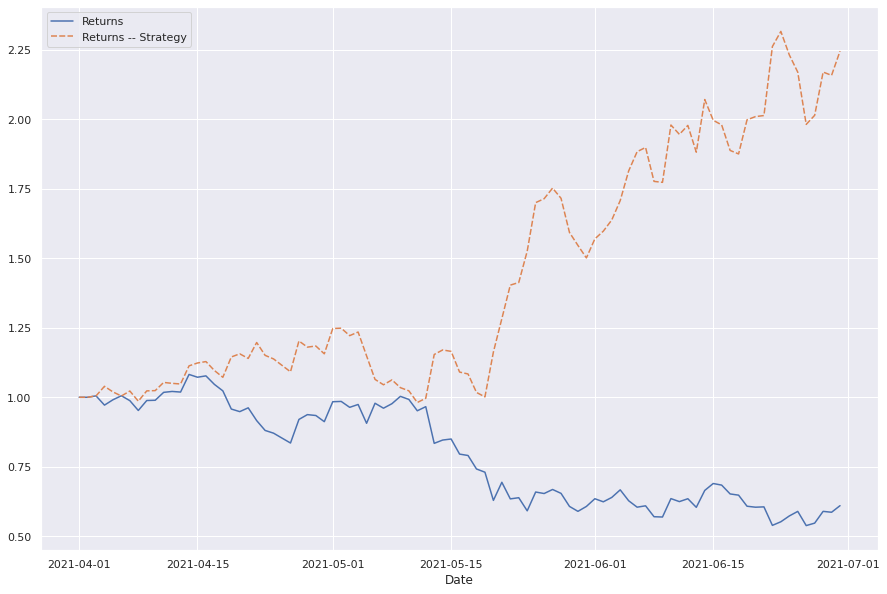

In [32]:
# Plot of cumulative returns based on the passive benchmark investment and strategy over time (regular scale).
plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=gross_performance, legend=False)
ax.legend(['Returns', 'Returns -- Strategy'])
plt.show()

Please note that even though our algorithm performs well relative to the passive benchmark investment, this might be a mere fluke. Therefore, it is suggested to test this algorithm with various assets and markets to check its robustness and reliability. In addition to that, as we have dropout layers in our model, we can also do Monte Carlo (MC) Dropout to get a sense of uncertainty in our prediction.

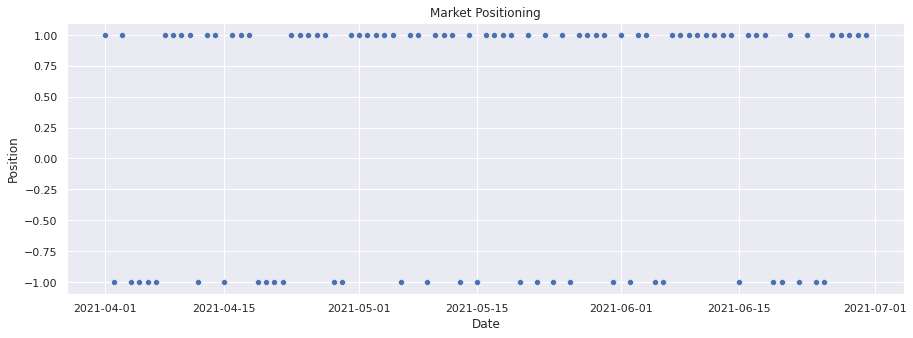

In [33]:
# Plot of market position over time.
plt.figure(figsize=(15, 5))
ax = sns.scatterplot(data=test_data['prediction'])
ax.set(xlabel='Date', ylabel='Position', title='Market Positioning')
plt.show()

Even though we are not changing our position with high frequency, it is preferred to add the transaction costs as to simulate a more realistic scenario.

## Summary

The holy grail of finance is predicting future market moves. It entails overcoming market efficiency. As a result of the tremendous success of trainable algorithms, an increasing number of traders are constructing deep learning-based algorithms to improve their profits. As we have seen from our experiment, Transformers might capture specific hidden patterns that might help us predict future market direction. 

This project motivates an individual to try this neural architecture and test it more vigorously to evaluate its performance in the given task.